# Model2
大竹さんのデータ処理
1. 円周方向に窓20で移動平均
2. 円周方向に25ずつ平均プーリング
3. 骨軸方向に3ステップずつデータ削減
4. 特徴量にノイズを入力（確率共鳴）

と全く同じ処理を施し得られたデータを大竹さんが試した機械学習モデル

random forest, gradient boosting,  ridge regressor, svm

に入力して、回帰学習を行う。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from scipy import stats
from tqdm import tqdm
from collections import namedtuple
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn import metrics

In [ ]:
# @title Original function
def pooling(df,spl = 10):
  col = np.arange(int(df.shape[1]/spl))*spl
  pool_val = [];col_ = []
  for i in range(len(col[:-1])):
    pool_val.append(df.values[:, col[i]:col[i+1]].mean(1))
    col_.append(np.mean(df.columns[col[i]:col[i+1]].astype('float64')))
  pool_val.append(df.values[:, col[-1]:].mean(1))
  col_.append(np.mean(df.columns[col[-1]:].astype('float64')))
  return pd.DataFrame(np.array(pool_val).T,columns = col_,index = df.index)

def train_(X,y,model,cv = 10,label = 'aBMD $[g/cm^2]$'):
  res_pred = np.zeros_like(y);r2_add=[]
  cv = KFold(n_splits=cv, shuffle=True, random_state=1234)
  for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = model.fit(X_train,y_train)
    pred = model.predict(X_test)
    res_pred[test_index] = pred
    print('r2 = ', metrics.r2_score(y_test,pred))
    r2_add.append(metrics.r2_score(y_test,pred))
  print('All r2 = ', metrics.r2_score(y,res_pred))
  print('Mean r2 = ', round(np.mean(r2_add),5),'±', round(np.std(r2_add),5))
  showGraph(y,res_pred,label = label,dpi=100)
  return res_pred, metrics.r2_score(y,res_pred)

def showGraph(y,res_pred,label = 'aBMD $[g/cm^2]$',dpi=100,figsize =(4,4)):
  plt.figure(figsize=figsize,dpi=dpi)
  plt.plot(y,res_pred,'.' ,c = 'k')
  correlationLine(y,res_pred,score = 'r2')
  plt.legend(edgecolor='none')
  plt.xlabel('Reference '+label)
  plt.ylabel('Predicted '+label)
  plt.show()
  plt.figure(figsize=figsize,dpi=dpi)
  plt.plot((y+res_pred)/2,y-res_pred,'.' ,c = 'k')
  max_ = max((y+res_pred)/2)
  min_ = min((y+res_pred)/2)
  mean_ = np.mean(y-res_pred)
  upp_ = mean_+1.96*np.std(y-res_pred)
  low_ = mean_-1.96*np.std(y-res_pred)
  plt.plot([min_,max_],[mean_,mean_],':',c = 'k')
  plt.plot([min_,max_],[upp_,upp_],'-.',c = 'k')
  plt.plot([min_,max_],[low_,low_],'-.',c = 'k')
  correlationLine((y+res_pred)/2,y-res_pred)
  plt.legend(edgecolor='none')
  label_ = 'Mean of predicted and reference '+label
  plt.xlabel(label_)
  label_ = 'Difference between \n predicted and reference '+label
  plt.ylabel(label_)
  plt.show()
  print('loa_upper: ',round(upp_,5))
  print('loa_lower: ',round(low_,5))
  print("Mean: ",mean_)

def correlationLine(x,y,score = 'r'):
  x = np.array(x).flatten()
  y = np.array(y).flatten()
  #相関
  if score =='r':
    slope, intercept, r_value, _, _ = stats.linregress(x,y)
    r, p = stats.pearsonr(x,y)
    print(stats.spearmanr(x,y))
    label_ = "r = "+str(round(r_value,3))
  if score == 'r2':
    r_value = metrics.r2_score(x,y)
    label_ = "$r^2$ = "+str(round(r_value,3))
    print('pearsonr:',stats.pearsonr(x,y))
  ysub = np.poly1d(np.polyfit(x,y,1))(x)
  xx = [x.min(),x.max()]
  yy = [ysub.min(),ysub.max()]
  if r_value < 0:
    yy = [ysub.max(),ysub.min()]
  plt.plot(xx,yy,"--",color="0.2",label = label_)

In [ ]:
version = "ellipse"
path = f"/content/drive/MyDrive/Tamura/ML/{version}/dataset/"

files = glob.glob(f"{path}opt_result/*.csv")
sim_params = pd.read_csv(f"{path}params.csv", index_col=0)
len(files)

1261

In [ ]:
def process(df, window, spl, step):
  df_1 = df.rolling(window, axis=1).mean().dropna(axis=1)
  df_2 = pooling(df_1, spl=spl)
  df_3 = df_2[::step]
  data = np.log(df_3.values + 1).flatten()
  return data

In [ ]:
nn = 1211
spl = 25; window = 20; step = 1
#spl=25; window=20; step=3 # 大竹さんのパラメータ
#spl=25; window=20; step=1 # 田村のパラメータ

dataset = pd.DataFrame()
for i in tqdm(range(nn)):
  df = pd.read_csv(files[i], index_col=0).fillna(0)
  data = process(df, window, spl, step)

  filename = files[i].split('/')[-1].split('.')[0]
  target = sim_params[sim_params["filename"]==filename]["aBMD"]
  subset = pd.Series(np.append(data, target), name=filename, index=[f"var{i}" for i in range(data.size)]+["target"])
  dataset = pd.concat([dataset, subset.to_frame().T])
dataset.head()

100%|██████████| 1211/1211 [01:12<00:00, 16.67it/s]


,var0,var1,var2,var3,var4,var5,var6,var7,var8,var9,...,var641,var642,var643,var644,var645,var646,var647,var648,var649,target
2023-10-20T23-22-02_it0011,1.808740e-10,1.992295e-09,5.364458e-09,5.257858e-08,5.601098e-07,0.000007,0.000041,0.000027,0.000003,3.122404e-07,...,7.294322e-07,0.000004,0.000016,0.000037,0.000008,8.476489e-07,8.152303e-08,1.548392e-08,1.281920e-09,1.096468
2023-10-23T16-48-33_it0063,1.200021e-09,8.147397e-09,1.659211e-08,1.515353e-07,1.135506e-06,0.000012,0.000062,0.000040,0.000006,7.476691e-07,...,1.543588e-06,0.000007,0.000026,0.000058,0.000014,1.749947e-06,1.794522e-07,4.442874e-08,6.177708e-09,0.981377
2023-10-20T23-59-26_it0012,5.372724e-11,6.845204e-10,3.342389e-09,3.073142e-08,3.181402e-07,0.000004,0.000026,0.000016,0.000002,1.788071e-07,...,4.134648e-07,0.000002,0.000010,0.000022,0.000004,4.695191e-07,3.984353e-08,7.128759e-09,5.484302e-10,1.043875
2023-10-21T00-40-23_it0013,2.218548e-09,1.297812e-08,2.806134e-08,1.951429e-07,1.391855e-06,0.000014,0.000074,0.000048,0.000006,8.371023e-07,...,1.847913e-06,0.000008,0.000029,0.000064,0.000015,1.966232e-06,2.560726e-07,5.131790e-08,8.209426e-09,0.732898
2023-10-23T17-02-08_it0045,5.881129e-10,3.425092e-09,8.040996e-09,7.753927e-08,6.214238e-07,0.000006,0.000035,0.000022,0.000003,3.716734e-07,...,8.065440e-07,0.000004,0.000015,0.000034,0.000007,8.858454e-07,8.514556e-08,1.880708e-08,2.806821e-09,0.977665


In [ ]:
features = dataset.drop('target',axis=1).columns
X = dataset[features].values
X = (X - X.mean(0)) / X.std(0)
y = dataset.target.values

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [ ]:
# @title Random Forest
ml = namedtuple("ml", ["name", "model", "params"])
ml = ml("RF",
        RandomForestRegressor(),
       {"n_estimators": [10, 20, 50, 100, 300],
        "max_features": ["log2", "sqrt", 1.0],
        "max_depth": [10, 20, 30, 40, 50],
        "n_jobs": [-1]
        })

In [ ]:
# @title Gradient Tree Boosting
ml = namedtuple("ml", ["name", "model", "params"])
ml = ml("GTB",
        GradientBoostingRegressor(),
        {"n_estimators": [10, 20, 50, 100, 300],
         "max_features": ["log2", "sqrt", 1.0],
         "max_depth": [1, 2, 3, 4, 5],
         "learning_rate": [0.001, 0.01, 0.1, 1.0, 10],
         })

In [ ]:
# @title Support Vector Machine
ml = namedtuple("ml", ["name", "model", "params"])
ml = ml("SVM",
        SVR(),
       {"kernel": ["rbf"],
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "gamma": [0.001, 0.01, 0.1, 1, 10, 100],
        })

In [ ]:
# @title Ridge Regressor
ml = namedtuple("ml", ["name", "model", "params"])
ml = ml("RR",
        Ridge(),
       {"alpha": [0.001, 0.01, 0.1, 1.0, 10],
        "fit_intercept": [True, False]
        })

In [ ]:
grid_search = GridSearchCV(ml.model, ml.params, cv=10, n_jobs=-1, scoring='r2')
grid_search.fit(X_train_val, y_train_val)
print(f"Model: {ml.model}")
print(f"Best params: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")
print(f"Test score: {grid_search.score(X_test, y_test)}")

Model: RandomForestRegressor()
Best params: {'max_depth': 50, 'max_features': 1.0, 'n_estimators': 300, 'n_jobs': -1}
Best score: 0.15008490226486834
Test score: 0.18715627288623693


In [ ]:
result = {}

r2 =  0.14877817247818392
r2 =  0.15856136538808452
r2 =  0.12451561340639128
r2 =  0.07156795494247259
r2 =  0.18416022450877167
r2 =  0.05882947533595029
r2 =  0.10815535617212779
r2 =  0.19728654159849168
r2 =  0.14531090881055542
r2 =  0.14032870420849008
All r2 =  0.14016519569829822
Mean r2 =  0.13375 ± 0.04221
pearsonr: PearsonRResult(statistic=0.41887732794184934, pvalue=1.2230357926419602e-52)


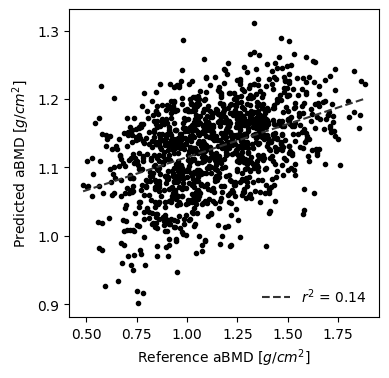

SignificanceResult(statistic=0.9122383591861174, pvalue=0.0)


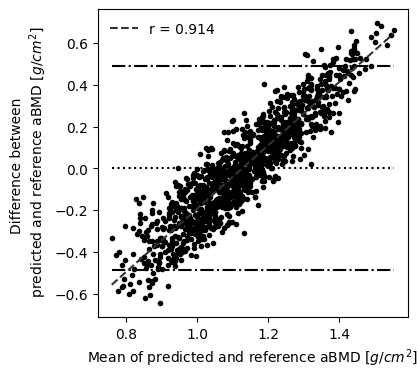

loa_upper:  0.48843
loa_lower:  -0.48858
Mean:  -7.644911215317824e-05
r2 =  0.21132701712227397
r2 =  0.1718911953089245
r2 =  0.1572774603005671
r2 =  0.12676324711751197
r2 =  0.19219411203646575
r2 =  0.1179343258617086
r2 =  0.1657191744535098
r2 =  0.2413012064247616
r2 =  0.21512119243023098
r2 =  0.21401783851156542
All r2 =  0.18605491585231748
Mean r2 =  0.18135 ± 0.03838
pearsonr: PearsonRResult(statistic=0.4912510755041662, pvalue=1.4488453337516868e-74)


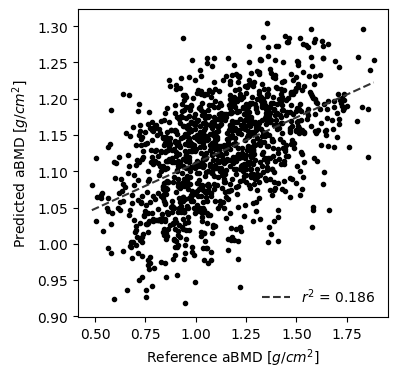

SignificanceResult(statistic=0.900138902111816, pvalue=0.0)


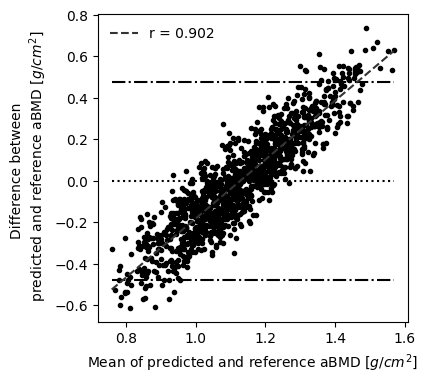

loa_upper:  0.47516
loa_lower:  -0.47542
Mean:  -0.00012754861385077097
r2 =  0.2175634634738124
r2 =  0.16999778577798608
r2 =  0.17980314221570204
r2 =  0.13351871233846613
r2 =  0.20502926111349262
r2 =  0.13278386678744414
r2 =  0.16962685491574125
r2 =  0.24092194505224052
r2 =  0.22492568206746522
r2 =  0.21453101428232102
All r2 =  0.19376062408073735
Mean r2 =  0.18887 ± 0.03574
pearsonr: PearsonRResult(statistic=0.5059951881479547, pvalue=1.0240220192027934e-79)


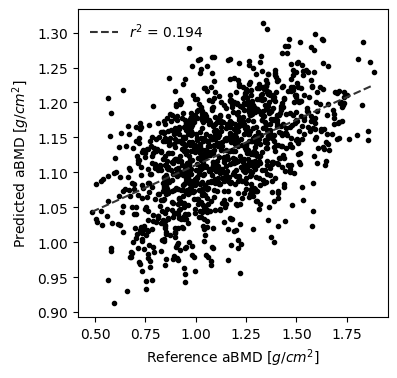

SignificanceResult(statistic=0.9010853040862977, pvalue=0.0)


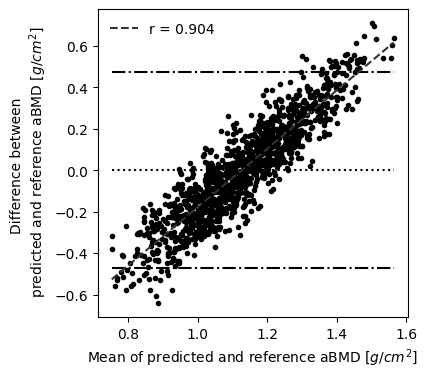

loa_upper:  0.47335
loa_lower:  -0.47272
Mean:  0.0003135557004717495
r2 =  0.2137482169083107
r2 =  0.1981460696929508
r2 =  0.17784475896863838
r2 =  0.13281463283699024
r2 =  0.19489473807246427
r2 =  0.12284206501283457
r2 =  0.176973680760657
r2 =  0.22030994442167484
r2 =  0.21644176154193562
r2 =  0.20639379932518698
All r2 =  0.1912726474790053
Mean r2 =  0.18604 ± 0.03238
pearsonr: PearsonRResult(statistic=0.5012929251783265, pvalue=4.791409205009783e-78)


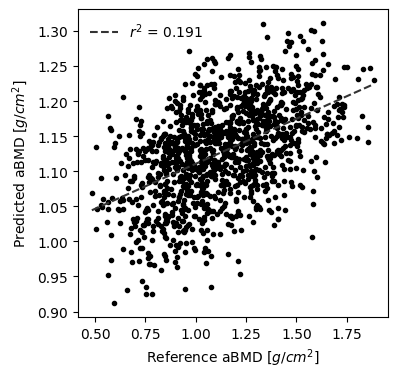

SignificanceResult(statistic=0.9000973335078419, pvalue=0.0)


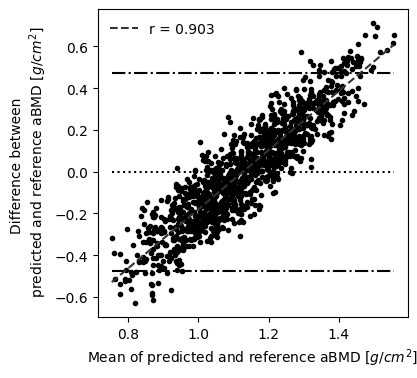

loa_upper:  0.47391
loa_lower:  -0.47362
Mean:  0.0001481291332464317
r2 =  0.20981864087071245
r2 =  0.18557863893766502
r2 =  0.16451312080744784
r2 =  0.1371865321258856
r2 =  0.20410249651861534
r2 =  0.1285928748579379
r2 =  0.16813257194868703
r2 =  0.2383929713120393
r2 =  0.21587524639194
r2 =  0.2054314589918934
All r2 =  0.19072394306542417
Mean r2 =  0.18576 ± 0.03372
pearsonr: PearsonRResult(statistic=0.5028136496538959, pvalue=1.390538093994854e-78)


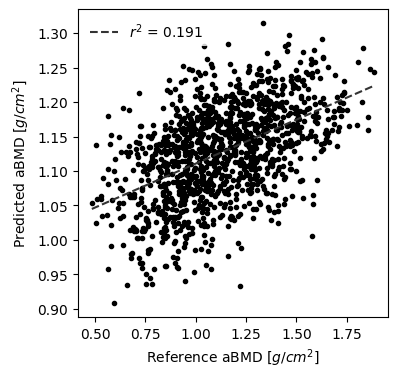

SignificanceResult(statistic=0.9017436786092842, pvalue=0.0)


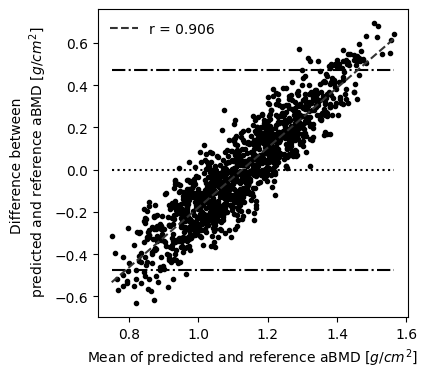

loa_upper:  0.47414
loa_lower:  -0.47371
Mean:  0.00021875232334027877


In [ ]:
sub_result = []
sigma = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
ml.model.set_params(**grid_search.best_params_)
for scale in sigma:
  noise = np.random.normal(scale=scale, size=dataset.drop('target', axis=1).shape)
  pred_, r2 = train_(X + noise, y, ml.model, cv=10, label="aBMD $[g/cm^2]$")
  sub_result.append(r2)
result[ml.name] = sub_result

In [ ]:
df = pd.DataFrame(result, index=sigma)
df

,RF
0.10000,0.140165
0.01000,0.186055
0.00100,0.193761
0.00010,0.191273
0.00001,0.190724


In [ ]:
path = f"/content/drive/MyDrive/Tamura/ML/{version}/result/"

f_num = len(glob.glob(f"{path}*.csv"))
df.to_csv(f"{path}{f_num + 1}.csv")

# メモ
- ガウシアンノイズを加えても精度は向上しなかった。
ノイズなし(r2=0.53)、ノイズあり(r2=0.53)。このことから軟組織(真皮、皮下組織)の厚さが可変であるモデルには確率共鳴現象は精度向上に寄与していると考えられる。田村のモデルでは軟組織の厚さは固定しているため意味がなかったと考えられる。

確率共鳴大竹さん処理結果

[f(name='RR', acc=[0.26121611324503946, 0.30434733159959093, 0.3077353610283894, 0.3076681518122871, 0.3076978496065531]),
 f(name='SVM', acc=[0.23153487613682566, 0.5178072395609631, 0.5296275683635008, 0.5301453860781391, 0.5301396599015074]),
 f(name='GTB', acc=[0.1212905549195864, 0.19561278427888296, 0.20553184152726167, 0.18856699101442365, 0.19958828068966028]),
 f(name='RF', acc=[0.11997449173856944, 0.17867608615002073, 0.17710782648638546, 0.1758910654382685, 0.1771821226117246])]

 確率共鳴田村処理結果

 [f(name='RR', acc=[0.14484942912659526, 0.2243413794545025, 0.22362562671798225, 0.22427850519493553, 0.2243470126432675]),
 f(name='SVM', acc=[0.4252055351310924, 0.6023078991398277, 0.6080358057717545, 0.6071305363920688, 0.6071736514212438]),
 f(name='GTB', acc=[0.13836914772978148, 0.23358328901132475, 0.2642084284885047, 0.2508399336851834, 0.25091740624214987])]